In [2]:
import numpy as np
import torch
import scanpy as sc
from data import PertDataloader, Network


model_name = 'Best_GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()


if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if args['dataset'] == 'Norman2019':
    data_path = '/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts.h5ad'

adata = sc.read_h5ad(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [5]:
G = network.G

In [4]:
# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    
## sort perturbations by characters to align a little bit
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])
sort_idx = np.argsort(list(condition2mean_expression.keys()))
mean_expression = mean_expression[sort_idx]
pert_list = np.array(list(condition2mean_expression.keys()))[sort_idx]

ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]

most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]

# calculate MSE
from sklearn.metrics.pairwise import euclidean_distances
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
x = euclidean_distances(mean_expression[:, most_variable_genes])**2/200
x_delta = euclidean_distances(mean_expression[:, most_variable_genes] - ctrl[:, most_variable_genes])**2/200

unique_perturbs = []
for i in adata.obs.condition.unique():
    if '+' in i:
        unique_perturbs.append(i.split('+')[0])
        unique_perturbs.append(i.split('+')[1])

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'correlation of delta')

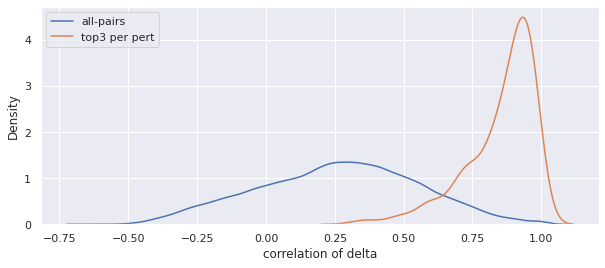

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
## the existence of digital twin of perts
sns.set(rc={'figure.figsize':(10, 4)})

corr = pd.DataFrame(mean_expression - ctrl).T.corr().values
sns.distplot(corr.reshape(-1,), hist = False, label = 'all-pairs')
sns.distplot(np.sort(corr, axis = 1)[:, -3], hist = False, label = 'top3 per pert')
plt.legend()
plt.xlabel('correlation of delta')


In [15]:
d_corr = pd.DataFrame(pert_list[np.flip(np.argsort(corr, axis = 1)[:, :-1], axis = 1)]).rename(columns = dict(zip(range(1, len(pert_list)-1), ['sim top' + str(i) for i in range (1,len(pert_list)-1)])))
d_corr = d_corr.rename(columns = {0: 'query_pert'})
pd.set_option('display.max_rows', d_corr.shape[0]+1)
d = d_corr
corr_mat = pd.DataFrame(np.flip(np.sort(corr, axis = 1)[:, :-1], axis = 1)).rename(columns = dict(zip(range(1, len(pert_list)-1), ['sim top' + str(i) for i in range (1,len(pert_list)-1)])))
corr_mat = corr_mat.rename(columns = {0: 'query_pert'})

In [16]:
mse = pd.DataFrame(np.sort(x, axis = 1)).rename(columns = dict(zip(range(1, len(pert_list)), ['sim top' + str(i) for i in range (1,len(pert_list))])))
mse = mse.rename(columns = {0: 'query_pert'})
def combo_or_not(x):
    if (x.split('+')[0] == 'ctrl') or (x.split('+')[1] == 'ctrl'):
        return False
    else:
        return True
    
combo = d[d.query_pert.apply(lambda x: combo_or_not(x))]
combo_mse = mse[d.query_pert.apply(lambda x: combo_or_not(x))]
combo_corr = corr_mat[d.query_pert.apply(lambda x: combo_or_not(x))]
single = d[~d.query_pert.apply(lambda x: combo_or_not(x))]
single_mse = mse[~d.query_pert.apply(lambda x: combo_or_not(x))]
single_corr = corr_mat[~d.query_pert.apply(lambda x: combo_or_not(x))]

In [21]:
pert2idx = dict(zip(pert_list, range(len(pert_list))))
corr_pair = []
G_ud = G.to_undirected()
from tqdm import tqdm
import networkx as nx
for i in tqdm(single.query_pert.values):
    if '+' in i:
        a = i.split('+')[0]
        b = i.split('+')[1]
        if a == 'ctrl':
            pert = b
        else:
            pert = a
    for j in single.query_pert.values:
        if '+' in j:
            a = j.split('+')[0]
            b = j.split('+')[1]
            if a == 'ctrl':
                pert2 = b
            else:
                pert2 = a
                
            if pert != pert2:
                try:
                    corr_pair.append((pert, pert2,
                                      corr[pert2idx[i]][pert2idx[j]], x[pert2idx[i]][pert2idx[j]],
                                      nx.shortest_path_length(G, source = pert, target = pert2),
                                      len(sorted(nx.common_neighbors(G_ud, pert, pert2))),
                                      next(nx.jaccard_coefficient(G_ud, [(pert, pert2)]))[2],
                                      next(nx.resource_allocation_index(G_ud, [(pert, pert2)]))[2],
                                      next(nx.preferential_attachment(G_ud, [(pert, pert2)]))[2]
                     ))
                except:
                    pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:04<00:00, 33.02it/s]


In [22]:
corr_pair

[('AHR',
  'ARID1A',
  0.5268913972178929,
  0.058683462,
  2,
  8,
  0.09523809523809523,
  0.07370336062930366,
  1827),
 ('AHR',
  'ARRDC3',
  0.40929883067596307,
  0.026909223,
  2,
  1,
  0.013157894736842105,
  0.0070921985815602835,
  882),
 ('AHR',
  'ATL1',
  0.5408234804886123,
  0.061678324,
  2,
  1,
  0.0125,
  0.007518796992481203,
  1134),
 ('AHR',
  'BAK1',
  -0.029343152237950868,
  0.04030081,
  2,
  2,
  0.02531645569620253,
  0.0073414477898782835,
  1134),
 ('AHR',
  'BCL2L11',
  0.10236178267315998,
  0.035755314,
  2,
  15,
  0.11278195488721804,
  0.08766103004100896,
  5355),
 ('AHR', 'BCORL1', 0.2512922071275406, 0.037369445, 3, 0, 0.0, 0, 504),
 ('AHR',
  'BPGM',
  0.36595593973021906,
  0.053046282,
  2,
  1,
  0.0125,
  0.0020325203252032522,
  1134),
 ('AHR', 'C19orf26', 0.39256224295771996, 0.03044958, 3, 0, 0.0, 0, 126),
 ('AHR',
  'CBFA2T3',
  0.17433561340894985,
  0.05327529,
  2,
  1,
  0.011764705882352941,
  0.0044444444444444444,
  1449),
 ('AHR'

In [ ]:
nx.shortest_path_length(G, source = 'ETS2', target = '')